In [1]:
# Código para que los resultados no se corten
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [2]:
# conditional install
try:
  from pytorch_tabnet.tab_model import TabNetClassifier
except ModuleNotFoundError:
  if 'google.colab' in str(get_ipython()):
    %pip install pytorch-tabnet

  from pytorch_tabnet.tab_model import TabNetClassifier

<IPython.core.display.Javascript object>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 604.5 kB/s eta 0:00:00


In [3]:
import random
import os
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score, balanced_accuracy_score, roc_auc_score, matthews_corrcoef, f1_score
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.augmentations import ClassificationSMOTE
import seaborn as sns

<IPython.core.display.Javascript object>

In [4]:
# Función para definir en un solo lugar todas las semillas
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_value = 42
seed_everything(seed_value)

<IPython.core.display.Javascript object>

Leemos el archivo y seleccionamos las features

In [5]:
df = pd.read_csv('postprandial_hypoglycemias.csv')

physiological_features = ['glucose','cho','next_iob','cob','aob_3h','aob_6h']
physiological_features_no_glucose = ['cho','iob','next_iob','cob','aob_3h','aob_6h']
no_glucose_related_features = ['glucose','cho', 'basal', 'bolus_normal', 'total_bolus_squared','cob','next_iob','aob_3h','aob_6h']
no_glucose_related_features_exclude_aob = ['glucose','cho', 'basal', 'bolus_normal', 'total_bolus_squared','cob','next_iob']
more_features = ['glucose','glucose_range','glucose_rate_change','mean_glucose_1h','glucose_1h','glucose_30m','cho', 'basal', 'bolus_normal', 'total_bolus_squared','cob','next_iob','aob_3h','aob_6h']
more_features_exclude_aob = ['glucose','glucose_range','glucose_rate_change','mean_glucose_1h','glucose_1h','glucose_30m','cho', 'basal', 'bolus_normal', 'total_bolus_squared','cob','next_iob']
more_features_no_cob_no_iob = ['glucose','glucose_range','glucose_rate_change','mean_glucose_1h','glucose_1h','glucose_30m','cho', 'basal', 'bolus_normal', 'total_bolus_squared']
all_features = ['glucose','glucose_range','glucose_rate_change','mean_glucose_1h','glucose_1h','glucose_30m','cho', 'basal', 'bolus_normal', 'total_bolus_squared',
                'cob','next_iob','iob','aob_3h','aob_6h','hour']
selected_features = all_features
target = 'hypoglycemia_severe'
df = df[selected_features + [target]]
df = df.dropna()
df = df.reset_index(drop=True)
X = df.drop(target, axis=1)
y = df[target]


<IPython.core.display.Javascript object>

In [6]:
print(f'Total de registros: {len(df)}')
print(f'Total de registros con hipoglicemia severa: {np.count_nonzero(y == 1)}')

<IPython.core.display.Javascript object>

Total de registros: 654
Total de registros con hipoglicemia severa: 27


In [7]:
# Implementación de la métrica para F1 score
class F1Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)

        return f1_score(y_true, y_pred)

<IPython.core.display.Javascript object>

In [8]:
# Implementación de la métrica para MCC
class MCC(Metric):
    def __init__(self):
        self._name = "MCC"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred = np.argmax(y_score, axis=1)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        mcc_numerator = (tp * tn) - (fp * fn)
        mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        if mcc_denominator == 0:
            return 0
        else:
            return mcc_numerator / mcc_denominator

<IPython.core.display.Javascript object>

# **Cross Validation**
Implementación con CV para probar hiperparámetros y selección de features

In [9]:
from sklearn.model_selection import StratifiedKFold

n_steps = 5
k_folds = 5
gamma = 1.3
patience = 50
epochs = 150
aug = ClassificationSMOTE(p=0.3)
batch_size = 64
virtual_batch_size = 8

evaluation_metrics = ['MCC','auc']

skf = StratifiedKFold(n_splits=k_folds, shuffle=True)

accuracy_scores = []
sensitivity_scores = []
specificity_scores = []
auc_scores = []
f1_scores = []
mcc_scores = []
cms = []
all_metrics = []
all_feature_importances = []
roc_data = []

y_real = []
y_proba = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]
    X_test_fold = X_test_fold.values

    classes = np.unique(y_train_fold)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train_fold)
    class_weights_dict = dict(zip(classes, class_weights))

    classifier = TabNetClassifier(
                                  verbose=1,
                                  n_steps=n_steps,
                                  gamma=gamma,
                                  )

    classifier.fit(X_train_fold.values, y_train_fold.values,
                  eval_set=[(X_train_fold.values, y_train_fold.values)],
                  eval_name=['train'],
                  batch_size=batch_size,
                  virtual_batch_size=virtual_batch_size,
                  patience=patience,
                  max_epochs=epochs,
                  weights=class_weights_dict,
                  eval_metric= evaluation_metrics,
                  augmentations=aug
                  )
    y_pred_probs = classifier.predict_proba(X_test_fold)[:,1]
    y_proba.extend(y_pred_probs)
    y_real.extend(y_test_fold)

    y_pred = (y_pred_probs >= 0.5).astype(int)

    cm = confusion_matrix(y_test_fold, y_pred)
    cm_df = pd.DataFrame(cm,
                        index = ['Non-Hypoglycemic', 'Hypoglycemic'],
                        columns = ['Non-Hypoglycemic', 'Hypoglycemic'])
    cms.append(cm_df)

    fpr, tpr, thresholds = roc_curve(y_test_fold, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    roc_data.append((fpr,tpr,roc_auc))

    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    report = classification_report(y_test_fold, y_pred, target_names=['Non-Hypoglycemic', 'Hypoglycemic'], output_dict=True)
    f1Score = report['Hypoglycemic']['f1-score']
    mcc = matthews_corrcoef(y_test_fold, y_pred)
    accuracy = accuracy_score(y_test_fold, y_pred)
    balanced_acuracy = balanced_accuracy_score(y_test_fold, y_pred)
    metrics = {
        'MCC': mcc,
        'F1 Score (Hypoglycemia class)': f1Score,
        'Balanced accuracy': balanced_acuracy,
        'ROC AUC': roc_auc,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Classification Report': report
    }

    all_metrics.append(metrics)
    accuracy_scores.append(accuracy)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    auc_scores.append(roc_auc)
    f1_scores.append(f1Score)
    mcc_scores.append(mcc)

    print(f"Fold {fold + 1}, AUC: {roc_auc}, F1 score: {f1Score}, MCC: {mcc}")


    feature_importances = classifier.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': feature_importances
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    all_feature_importances.append(feature_importance_df)


<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.03043 | train_MCC: -0.05075| train_auc: 0.42683 |  0:00:03s
epoch 1  | loss: 0.7428  | train_MCC: -0.05637| train_auc: 0.41993 |  0:00:05s
epoch 2  | loss: 0.71503 | train_MCC: -0.06559| train_auc: 0.45527 |  0:00:06s
epoch 3  | loss: 0.68649 | train_MCC: -0.05116| train_auc: 0.45536 |  0:00:07s
epoch 4  | loss: 0.62809 | train_MCC: -0.09201| train_auc: 0.4256  |  0:00:09s
epoch 5  | loss: 0.61625 | train_MCC: -0.05747| train_auc: 0.53148 |  0:00:10s
epoch 6  | loss: 0.66183 | train_MCC: -0.01744| train_auc: 0.55534 |  0:00:11s
epoch 7  | loss: 0.63648 | train_MCC: -0.03167| train_auc: 0.52604 |  0:00:14s
epoch 8  | loss: 0.65019 | train_MCC: 0.01164 | train_auc: 0.59118 |  0:00:16s
epoch 9  | loss: 0.60516 | train_MCC: 0.09208 | train_auc: 0.6331  |  0:00:18s
epoch 10 | loss: 0.62568 | train_MCC: 0.0971  | train_auc: 0.72836 |  0:00:19s
epoch 11 | loss: 0.6083  | train_MCC: 0.08809 | train_auc: 0.69633 |  0:00:21s
epoch 12 | loss: 0.66671 | train_MCC: 0.10582 | trai

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 1, AUC: 0.8444444444444446, F1 score: 0.2857142857142857, MCC: 0.3269469102711142


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15157 | train_MCC: 0.03983 | train_auc: 0.47768 |  0:00:00s
epoch 1  | loss: 0.75724 | train_MCC: -0.02897| train_auc: 0.45854 |  0:00:01s
epoch 2  | loss: 0.69361 | train_MCC: -0.0544 | train_auc: 0.39149 |  0:00:02s
epoch 3  | loss: 0.69758 | train_MCC: 0.03231 | train_auc: 0.46725 |  0:00:02s
epoch 4  | loss: 0.64384 | train_MCC: 0.01318 | train_auc: 0.54609 |  0:00:03s
epoch 5  | loss: 0.64399 | train_MCC: -0.02017| train_auc: 0.58102 |  0:00:04s
epoch 6  | loss: 0.63183 | train_MCC: -0.00739| train_auc: 0.53656 |  0:00:04s
epoch 7  | loss: 0.64108 | train_MCC: 0.0016  | train_auc: 0.54219 |  0:00:05s
epoch 8  | loss: 0.62392 | train_MCC: 0.09815 | train_auc: 0.60924 |  0:00:05s
epoch 9  | loss: 0.64441 | train_MCC: 0.12265 | train_auc: 0.69579 |  0:00:06s
epoch 10 | loss: 0.60829 | train_MCC: 0.1266  | train_auc: 0.65641 |  0:00:07s
epoch 11 | loss: 0.56785 | train_MCC: 0.09048 | train_auc: 0.65424 |  0:00:08s
epoch 12 | loss: 0.5965  | train_MCC: 0.17612 | trai

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 2, AUC: 0.42380952380952386, F1 score: 0.06896551724137931, MCC: 0.008648183593331993


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06011 | train_MCC: 0.03974 | train_auc: 0.57427 |  0:00:00s
epoch 1  | loss: 0.79289 | train_MCC: -0.02203| train_auc: 0.51745 |  0:00:01s
epoch 2  | loss: 0.68745 | train_MCC: 0.07678 | train_auc: 0.57513 |  0:00:02s
epoch 3  | loss: 0.67236 | train_MCC: 0.02665 | train_auc: 0.5313  |  0:00:03s
epoch 4  | loss: 0.61425 | train_MCC: -0.02279| train_auc: 0.49279 |  0:00:04s
epoch 5  | loss: 0.62819 | train_MCC: 0.07564 | train_auc: 0.67995 |  0:00:04s
epoch 6  | loss: 0.63068 | train_MCC: 0.10719 | train_auc: 0.67957 |  0:00:05s
epoch 7  | loss: 0.59761 | train_MCC: 0.16354 | train_auc: 0.77044 |  0:00:06s
epoch 8  | loss: 0.63318 | train_MCC: 0.12852 | train_auc: 0.76143 |  0:00:06s
epoch 9  | loss: 0.63473 | train_MCC: 0.14259 | train_auc: 0.72311 |  0:00:07s
epoch 10 | loss: 0.65128 | train_MCC: 0.13494 | train_auc: 0.7583  |  0:00:08s
epoch 11 | loss: 0.60999 | train_MCC: 0.1586  | train_auc: 0.76172 |  0:00:08s
epoch 12 | loss: 0.60519 | train_MCC: 0.22144 | trai

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 3, AUC: 0.7266666666666666, F1 score: 0.14035087719298245, MCC: 0.12462230520355642


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13404 | train_MCC: -0.02463| train_auc: 0.49758 |  0:00:00s
epoch 1  | loss: 0.76404 | train_MCC: 0.14884 | train_auc: 0.66524 |  0:00:01s
epoch 2  | loss: 0.67189 | train_MCC: 0.03568 | train_auc: 0.58215 |  0:00:02s
epoch 3  | loss: 0.64106 | train_MCC: 0.07432 | train_auc: 0.61867 |  0:00:02s
epoch 4  | loss: 0.63131 | train_MCC: 0.07252 | train_auc: 0.65177 |  0:00:03s
epoch 5  | loss: 0.60677 | train_MCC: 0.06439 | train_auc: 0.62578 |  0:00:03s
epoch 6  | loss: 0.61944 | train_MCC: 0.05531 | train_auc: 0.65348 |  0:00:04s
epoch 7  | loss: 0.65081 | train_MCC: 0.04824 | train_auc: 0.66145 |  0:00:05s
epoch 8  | loss: 0.60971 | train_MCC: 0.19399 | train_auc: 0.72216 |  0:00:06s
epoch 9  | loss: 0.59253 | train_MCC: 0.19633 | train_auc: 0.73487 |  0:00:07s
epoch 10 | loss: 0.60677 | train_MCC: 0.20678 | train_auc: 0.75403 |  0:00:08s
epoch 11 | loss: 0.62196 | train_MCC: 0.1983  | train_auc: 0.74701 |  0:00:08s
epoch 12 | loss: 0.61934 | train_MCC: 0.17066 | trai

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 4, AUC: 0.5533333333333333, F1 score: 0.08, MCC: -0.0011803570529941851


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06848 | train_MCC: -0.09277| train_auc: 0.38519 |  0:00:00s
epoch 1  | loss: 0.73505 | train_MCC: 0.0688  | train_auc: 0.6073  |  0:00:01s
epoch 2  | loss: 0.71691 | train_MCC: 0.08538 | train_auc: 0.66009 |  0:00:02s
epoch 3  | loss: 0.69092 | train_MCC: 0.04119 | train_auc: 0.57371 |  0:00:02s
epoch 4  | loss: 0.65577 | train_MCC: 0.09184 | train_auc: 0.67222 |  0:00:03s
epoch 5  | loss: 0.65288 | train_MCC: 0.06074 | train_auc: 0.60621 |  0:00:04s
epoch 6  | loss: 0.64306 | train_MCC: 0.18379 | train_auc: 0.78586 |  0:00:04s
epoch 7  | loss: 0.63508 | train_MCC: 0.18827 | train_auc: 0.76585 |  0:00:05s
epoch 8  | loss: 0.59147 | train_MCC: 0.13309 | train_auc: 0.71414 |  0:00:06s
epoch 9  | loss: 0.60399 | train_MCC: 0.12934 | train_auc: 0.71405 |  0:00:07s
epoch 10 | loss: 0.60734 | train_MCC: 0.13672 | train_auc: 0.74701 |  0:00:08s
epoch 11 | loss: 0.63439 | train_MCC: 0.03695 | train_auc: 0.62061 |  0:00:08s
epoch 12 | loss: 0.58258 | train_MCC: 0.12686 | trai

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 5, AUC: 0.592, F1 score: 0.06451612903225806, MCC: 0.0


**Métricas agregadas**

In [10]:
y_real = np.array(y_real)
y_proba = np.array(y_proba)

aggregated_threshold = 0.5

y_pred = (y_proba >= aggregated_threshold).astype(int)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

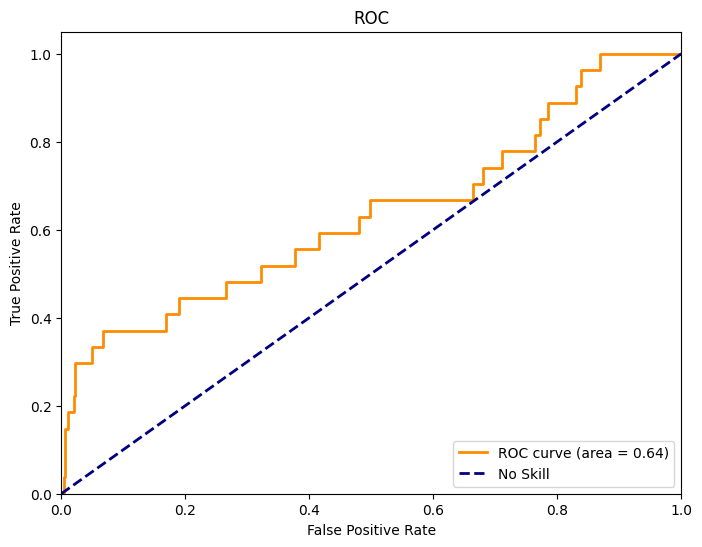

In [11]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_real, y_proba)
roc_auc = auc(fpr, tpr)
roc_data.append((fpr,tpr,roc_auc))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

<IPython.core.display.Javascript object>

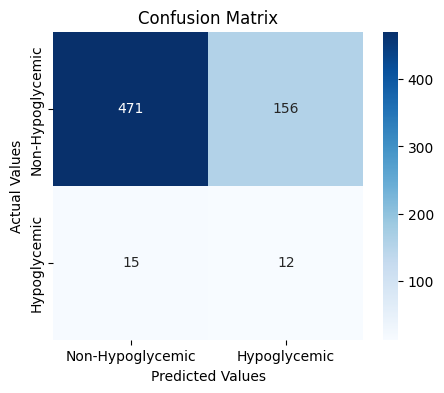

In [12]:
# Matriz de confusión agregada
cm = confusion_matrix(y_real, y_pred)
cm_df = pd.DataFrame(cm,
                    index = ['Non-Hypoglycemic', 'Hypoglycemic'],
                    columns = ['Non-Hypoglycemic', 'Hypoglycemic'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [13]:
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
report = classification_report(y_real, y_pred, target_names=['Non-Hypoglycemic', 'Hypoglycemic'], output_dict=True)
f1Score = f1_score(y_real, y_pred)
mcc = matthews_corrcoef(y_real, y_pred)
accuracy = accuracy_score(y_real, y_pred)
balanced_acuracy = balanced_accuracy_score(y_real, y_pred)
metrics = {
    'MCC': mcc,
    'F1 Score' : f1Score,
    'Balanced accuracy': balanced_acuracy,
    'ROC AUC': roc_auc,
    'Accuracy': accuracy,
    'Sensitivity': sensitivity,
    'Specificity': specificity,
    'Classification Report': report
}
metrics

<IPython.core.display.Javascript object>

{'MCC': 0.0890844494012448,
 'F1 Score': 0.12307692307692308,
 'Balanced accuracy': 0.5978203083466241,
 'ROC AUC': 0.6352413019079687,
 'Accuracy': 0.7385321100917431,
 'Sensitivity': 0.4444444444444444,
 'Specificity': 0.7511961722488039,
 'Classification Report': {'Non-Hypoglycemic': {'precision': 0.9691358024691358,
   'recall': 0.7511961722488039,
   'f1-score': 0.8463611859838275,
   'support': 627},
  'Hypoglycemic': {'precision': 0.07142857142857142,
   'recall': 0.4444444444444444,
   'f1-score': 0.12307692307692308,
   'support': 27},
  'accuracy': 0.7385321100917431,
  'macro avg': {'precision': 0.5202821869488536,
   'recall': 0.5978203083466241,
   'f1-score': 0.4847190545303753,
   'support': 654},
  'weighted avg': {'precision': 0.9320744947656263,
   'recall': 0.7385321100917431,
   'f1-score': 0.8165008265060194,
   'support': 654}}}

**Métricas media**

In [14]:
# Calcular la puntuació mitjana a través de tots els folds
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

mean_sensitivity = np.mean(sensitivity_scores)
std_sensitivity = np.std(sensitivity_scores)

mean_specificity = np.mean(specificity_scores)
std_specificity = np.std(specificity_scores)

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
mean_f1score = np.mean(f1_scores)
std_f1score = np.std(f1_scores)
mean_mcc = np.mean(mcc_scores)
std_mcc = np.std(f1_scores)

<IPython.core.display.Javascript object>

In [15]:
print(f"Accuracy mean: {mean_auc.round(2)}, Accuracy std: {std_auc.round(2)}")
print(f"Sensitivity mean: {mean_sensitivity.round(2)}, Sensibility std: {std_sensitivity.round(2)}")
print(f"Specificity mean: {mean_specificity.round(2)}, AUC std: {std_specificity.round(2)}")
print(f"AUC mean: {mean_auc.round(2)}, AUC std: {std_auc.round(2)}")
print(f"F1 score mean: {mean_f1score.round(2)}, F1 score std: {std_f1score.round(2)}")
print(f"MCC mean: {mean_mcc.round(2)}, MCC std: {std_mcc.round(2)}")

<IPython.core.display.Javascript object>

Accuracy mean: 0.63, Accuracy std: 0.15
Sensitivity mean: 0.44, Sensibility std: 0.25
Specificity mean: 0.75, AUC std: 0.09
AUC mean: 0.63, AUC std: 0.15
F1 score mean: 0.13, F1 score std: 0.08
MCC mean: 0.09, MCC std: 0.08


**Métricas por fold**

In [16]:
for i in range(k_folds):
    print(f"Fold {i + 1}: {all_metrics[i]}")

<IPython.core.display.Javascript object>

Fold 1: {'MCC': 0.3269469102711142, 'F1 Score (Hypoglycemia class)': 0.2857142857142857, 'Balanced accuracy': 0.8246031746031746, 'ROC AUC': 0.8444444444444446, 'Accuracy': 0.8473282442748091, 'Sensitivity': 0.8, 'Specificity': 0.8492063492063492, 'Classification Report': {'Non-Hypoglycemic': {'precision': 0.9907407407407407, 'recall': 0.8492063492063492, 'f1-score': 0.9145299145299146, 'support': 126}, 'Hypoglycemic': {'precision': 0.17391304347826086, 'recall': 0.8, 'f1-score': 0.2857142857142857, 'support': 5}, 'accuracy': 0.8473282442748091, 'macro avg': {'precision': 0.5823268921095008, 'recall': 0.8246031746031746, 'f1-score': 0.6001221001221002, 'support': 131}, 'weighted avg': {'precision': 0.9595641110742338, 'recall': 0.8473282442748091, 'f1-score': 0.8905293180102342, 'support': 131}}}
Fold 2: {'MCC': 0.008648183593331993, 'F1 Score (Hypoglycemia class)': 0.06896551724137931, 'Balanced accuracy': 0.5087301587301587, 'ROC AUC': 0.42380952380952386, 'Accuracy': 0.7938931297709

<IPython.core.display.Javascript object>

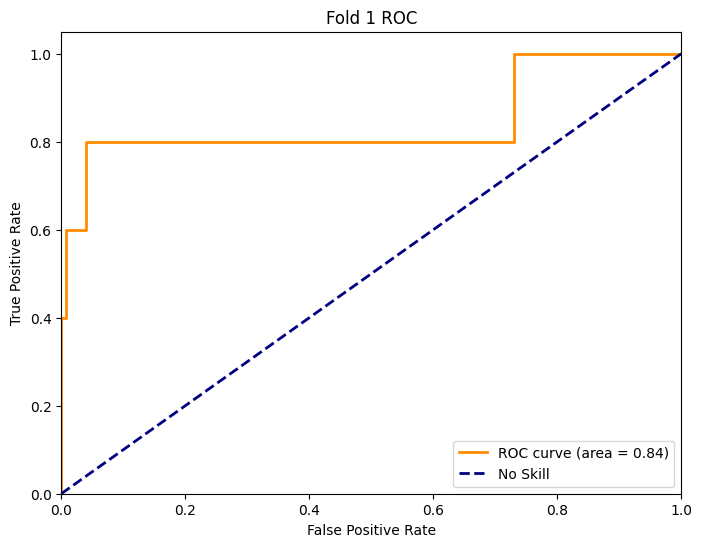

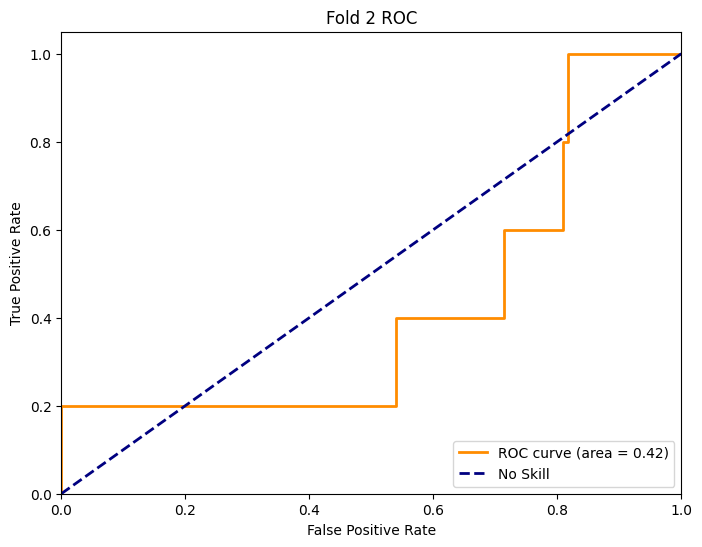

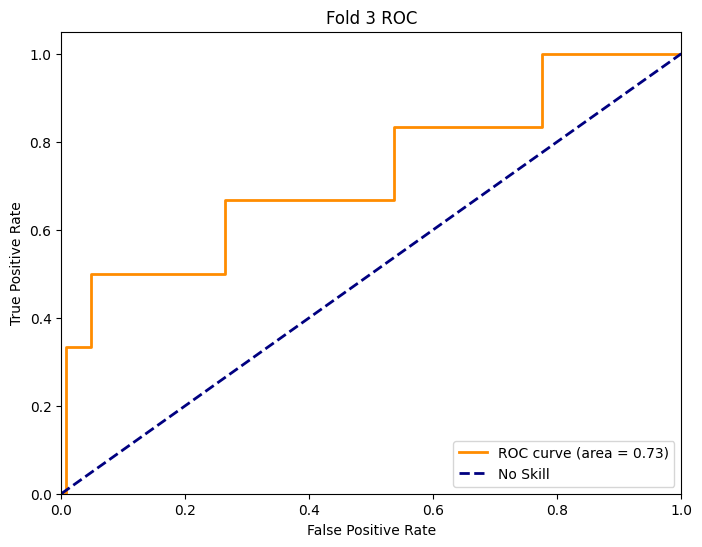

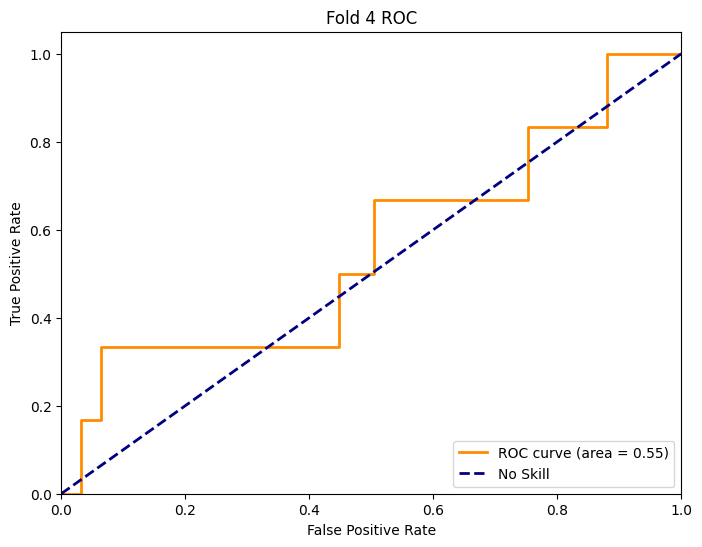

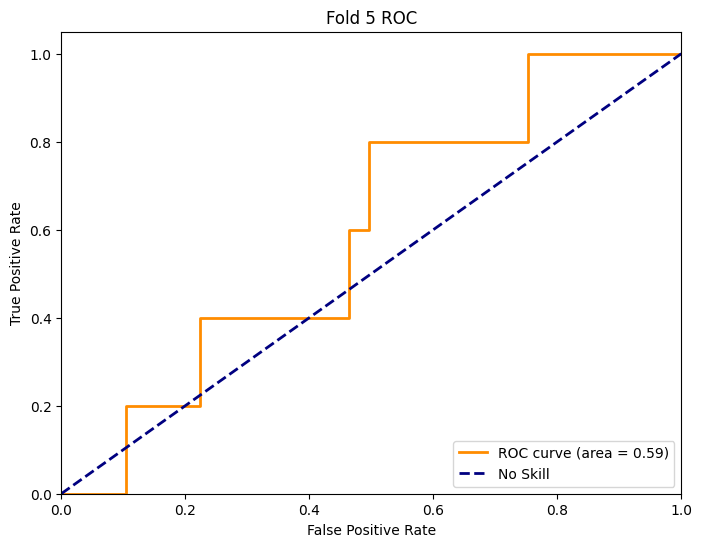

In [17]:
for i in range(k_folds):
    fpr, tpr, roc_auc = roc_data[i]
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Fold ' + str(i +1) + ' ROC')
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>

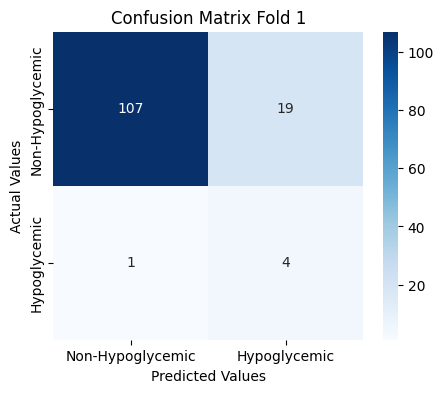

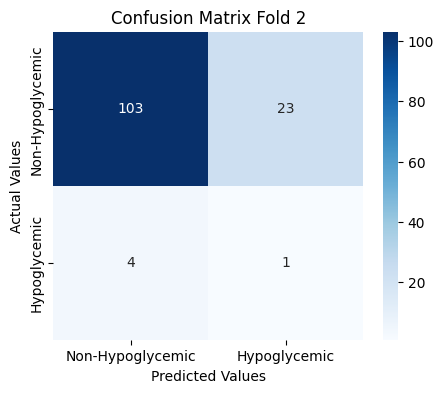

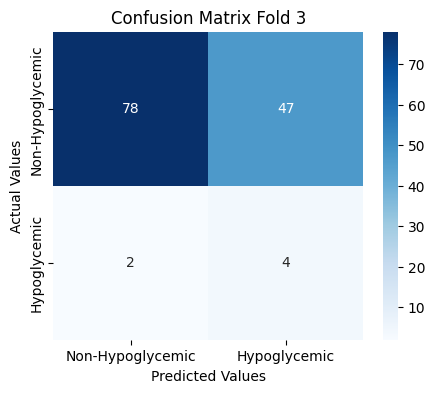

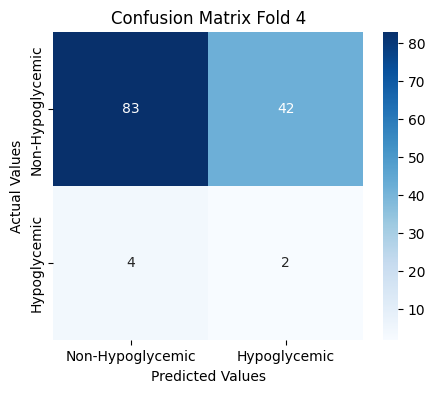

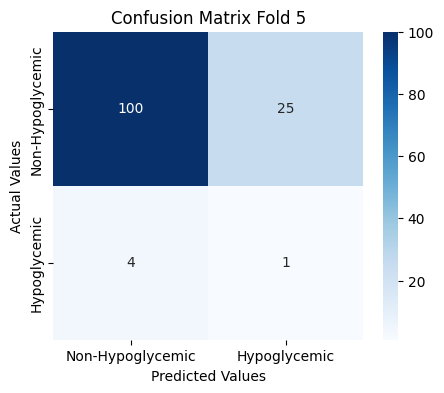

In [18]:
for i in range(k_folds):
  plt.figure(figsize=(5,4))
  sns.heatmap(cms[i], annot=True, cmap='Blues', fmt='g')
  plt.title('Confusion Matrix Fold '  + str(i + 1))
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()

In [19]:
for i in range(k_folds):
  print(f"Fold {i + 1}:")
  print(f"{all_feature_importances[i].to_string(index=False)}")

<IPython.core.display.Javascript object>

Fold 1:
            Feature  Importance
              basal    0.272604
        glucose_30m    0.223940
                cob    0.113381
    mean_glucose_1h    0.108745
glucose_rate_change    0.090524
                iob    0.038350
total_bolus_squared    0.036502
            glucose    0.036032
                cho    0.025113
               hour    0.020994
             aob_3h    0.013583
       bolus_normal    0.011834
           next_iob    0.004529
      glucose_range    0.003655
         glucose_1h    0.000214
             aob_6h    0.000000
Fold 2:
            Feature  Importance
           next_iob    0.178322
              basal    0.174811
                cob    0.162924
               hour    0.143919
             aob_6h    0.106909
        glucose_30m    0.100691
         glucose_1h    0.076978
                iob    0.036956
            glucose    0.015074
                cho    0.003274
             aob_3h    0.000141
      glucose_range    0.000000
glucose_rate_change    0

<IPython.core.display.Javascript object>

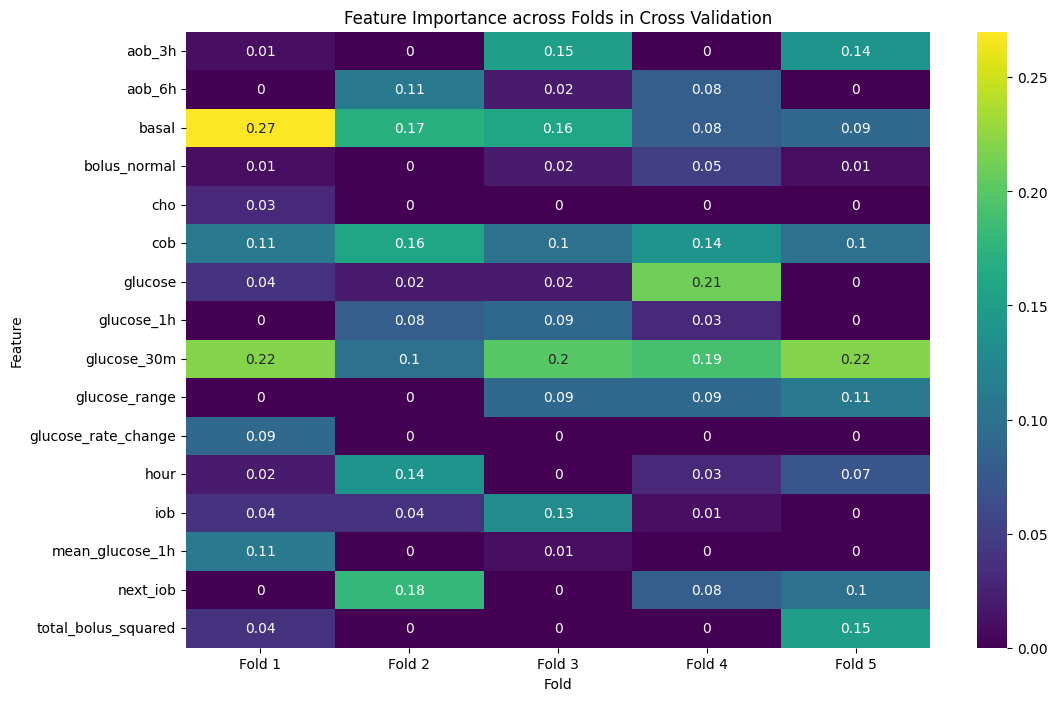

In [20]:
#Mapa de calor para representar la importancia de las características en las diferentes ejecuciones de la validación cruzada
feature_importances_combined = pd.DataFrame()

for i, df in enumerate(all_feature_importances):
    df = df.rename(columns={"Importance": f"Fold {i+1}"})
    if df.index.name != 'Feature':
        df = df.set_index('Feature')
    df = df.round(2)
    feature_importances_combined = feature_importances_combined.join(df, how="outer")

feature_importances_combined = feature_importances_combined.fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(feature_importances_combined, annot=True, cmap="viridis")
plt.title("Feature Importance across Folds in Cross Validation")
plt.ylabel("Feature")
plt.xlabel("Fold")
plt.show()